In [12]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import random
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [13]:
n_particle=30 # n particle
d=5 # dimension (x will be d dimension)
# x_step will be size(d*n_particle)
B=0
xinitial=torch.rand(d,n_particle)*6-3

In [14]:
def Rfunc(x,B):
    return (x-B)**2-10.*torch.cos(2.*np.pi*(x-B))+10.

def dL(x, d, B):
    delta=(2.*(x-B)+10.*torch.sin(2.*np.pi*(x-B))*2*np.pi)/d
    # delta=delta/torch.norm(delta)
    return delta


In [15]:
def step_charges(x,d,dt):
    x_step_new=x-dt*dL(x,d,B)
    return x_step_new

In [16]:
def step_charges_noise(x,d, dt,sigma):
    V=torch.sum(Rfunc(x,B),dim=0,keepdim=True)/d
    zerotensor=torch.zeros(1,n_particle)
    x_step_new=x-dt*dL(x,d,B)+sigma*torch.from_numpy(np.random.normal(0,dt,(1,n_particle)))*torch.max((V-torch.mean(V)).float(),zerotensor.float())
    return x_step_new

In [17]:
# basic gradient descent trajectory
def run_traj(x_step,d,n_steps,dt):
    #traj = [(ys,cs)]
    traj_x = torch.zeros([d,n_particle,n_steps])
    traj_L = torch.zeros(n_steps)
    for i in range(n_steps):
        traj_x[:,:,i] = x_step
        traj_L[i]=torch.mean(Rfunc(x_step,B))
        x_step= step_charges(x_step,d,dt)
        
    return traj_x,traj_L

In [18]:
# basic gradient descent trajectory
def run_traj_noise(x_step,d,n_steps,dt,sigma):
    #traj = [(ys,cs)]
    traj_x = torch.zeros([d,n_particle,n_steps])
    traj_L = torch.zeros(n_steps)
    for i in range(n_steps):
        traj_x[:,:,i] = x_step
        traj_L[i]=torch.mean(Rfunc(x_step,B))
        x_step= step_charges_noise(x_step,d,dt,sigma)
        
    return traj_x,traj_L

In [19]:
def kill(x_step, kill_inds):
    survivor_inds = torch.tensor(list(set(range(x_step.shape[1]))-set(kill_inds)), dtype=torch.long)
    x_step = torch.index_select(x_step,1,survivor_inds)
    return x_step

def run_traj_noise_bd(x_step,d,n_steps,alpha, dt,sigma):
    
    traj_x = torch.zeros([d,n_particle,n_steps])
    traj_L = torch.zeros(n_steps)
    total_pop = d
    for i in range(n_steps):

        # print('Xsize '+str(x_step.size()))

        traj_x[:,:,i] = x_step
        traj_L[i]=torch.mean(Rfunc(x_step,B))

        x_step= step_charges_noise(x_step,d,dt,sigma)
        V=torch.sum(Rfunc(x_step,B),dim=0,keepdim=True)/d
        # print('Vsize '+str(V.size()))
        kill_inds = []
        n_cloned = 0
        for i in range(n_particle):
            rate = alpha *(V[0,i]-torch.mean(V))
            r = np.random.rand()
            if rate > 0:
                if r < 1-torch.exp(-dt*rate):
                    kill_inds.append(i)
      
            elif r < 1-torch.exp(dt*rate):
                x_step = torch.cat((x_step,x_step[:,i].reshape(d,1)),1)
                n_cloned+=1
                
        # now kill the particles on the kill list
        x_step= kill(x_step,kill_inds)
        # print('Xsize '+str(x_step.size()))
        # and resample to control population
        delta_n = n_cloned-len(kill_inds)
        # print(x_step.size())
        if delta_n<0:
            clone_inds = torch.randint(n_particle+delta_n, (-delta_n,), dtype=torch.long)
            x_step = torch.cat((x_step,torch.index_select(x_step,1,clone_inds)),1)
        if delta_n>0:
            kill_inds = (torch.randperm(x_step.shape[1], dtype=torch.int)[:delta_n]).numpy()
            x_step = kill(x_step,kill_inds)
        # print(print('Xsize '+str(x_step.size())))
        # print(x_step.size())   

    # for i in range(n_steps-quench_steps, n_steps):
    #     traj[i,0,:] = ys.flatten()
    #     traj[i,1,:] = cs.flatten()
    #     ys, cs = step_charges(ys, cs,n,xsbatch,ysbatch,dt=dt)
        #traj.append((ys,cs))

            
    return traj_x,traj_L

In [20]:
def run_traj_bd(x_step,d,n_steps,alpha, dt):
    
    traj_x = torch.zeros([d,n_particle,n_steps])
    traj_L = torch.zeros(n_steps)
    total_pop = d
    for i in range(n_steps):

        # print('Xsize '+str(x_step.size()))

        traj_x[:,:,i] = x_step
        traj_L[i]=torch.mean(Rfunc(x_step,B))
        # print("matirxsize"+str(Rfunc(x_step,B).size()))
        x_step= step_charges(x_step,d,dt)
        V=torch.sum(Rfunc(x_step,B),dim=0,keepdim=True)/d
        # print("Vsize"+str(V.size()))
        # print('Vsize '+str(V.size()))
        kill_inds = []
        n_cloned = 0
        for i in range(n_particle):
            rate = V[0,i]-torch.mean(V)
            r = np.random.rand()
            if rate > 0:
                if r < 1-torch.exp(-dt*rate*alpha):
                    kill_inds.append(i)
      
            elif r < 1-torch.exp(dt*rate*alpha):
                x_step = torch.cat((x_step,x_step[:,i].reshape(d,1)),1)
                n_cloned+=1
        # print('Xsizeclone '+str(x_step.size()))
        # now kill the particles on the kill list
        x_step= kill(x_step,kill_inds)
        # print('Xsizekill '+str(x_step.size()))
        # and resample to control population
        delta_n = n_cloned-len(kill_inds)
        # print(x_step.size())
        if delta_n<0:
            clone_inds = torch.randint(n_particle+delta_n, (-delta_n,), dtype=torch.long)
            x_step = torch.cat((x_step,torch.index_select(x_step,1,clone_inds)),1)
        if delta_n>0:
            kill_inds = (torch.randperm(x_step.shape[1], dtype=torch.int)[:delta_n]).numpy()
            x_step = kill(x_step,kill_inds)
        # print(print('Xsize '+str(x_step.size())))   

    # for i in range(n_steps-quench_steps, n_steps):
    #     traj[i,0,:] = ys.flatten()
    #     traj[i,1,:] = cs.flatten()
    #     ys, cs = step_charges(ys, cs,n,xsbatch,ysbatch,dt=dt)
        #traj.append((ys,cs))

            
    return traj_x,traj_L

In [21]:
n_steps = 2000
dt=0.001
alpha=5
sigma=5
traj_x_gd,traj_L_gd = run_traj(xinitial,d,n_steps,dt)
traj_x_gd_noise,traj_L_gd_noise = run_traj_noise(xinitial,d,n_steps,dt,sigma)
traj_x_gd_bd,traj_L_gd_bd = run_traj_bd(xinitial,d,n_steps,alpha,dt)
traj_x_gd_noise_bd,traj_L_gd_noise_bd = run_traj_noise_bd(xinitial,d,n_steps,alpha, dt,sigma)
alpha=50
traj_x_gd_bd_50,traj_L_gd_bd_50 = run_traj_bd(xinitial,d,n_steps,alpha,dt)


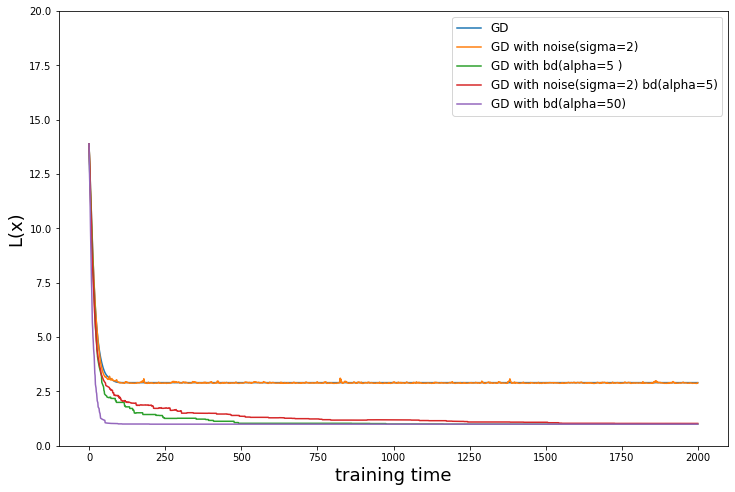

In [22]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.set_ylabel("L(x)", fontsize=18)
ax1.set_xlabel("training time", fontsize=18)
ax1.plot(traj_L_gd, label="GD",color=colors[0])
ax1.plot(traj_L_gd_noise, label="GD with noise(sigma=2)",color=colors[1])
ax1.plot(traj_L_gd_bd, label="GD with bd(alpha=5 )",color=colors[2])
ax1.plot(traj_L_gd_noise_bd, label="GD with noise(sigma=2) bd(alpha=5)",color = colors[3])
ax1.plot(traj_L_gd_bd_50, label="GD with bd(alpha=50)",color=colors[4])
ax1.legend(fontsize=12)
ax1.set_ylim(0,20)
plt.show()